In [177]:
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np

In [178]:
df = pd.read_csv('transactions.csv')

if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)


In [179]:
df['prix_m2'] = df['prix'] / (df['surface_habitable'])

In [180]:
idf_df = df[df.departement.isin([75, 77, 78, 91, 92, 93, 94, 95 ]) & (df.date_transaction.str.startswith('2022-'))].copy()

surface_cols = [c for c in idf_df.columns if 'surface_' in c and c != 'surface_habitable']
for c in surface_cols:
    idf_df[c + '_sum'] = idf_df[c].apply(lambda x: sum(eval(x)) if 'NULL' not in x else 0)
idf_df = idf_df[idf_df[[c + '_sum' for c in surface_cols]].sum(axis=1) == 0]

idf_df.to_csv('transactions_idf.csv')

In [191]:
idf_df = pd.read_csv('transactions_idf.csv')

In [192]:
idf_df.columns

Index(['Unnamed: 0', 'id_transaction', 'date_transaction', 'prix',
       'departement', 'id_ville', 'ville', 'code_postal', 'adresse',
       'type_batiment', 'vefa', 'n_pieces', 'surface_habitable',
       'id_parcelle_cadastre', 'latitude', 'longitude', 'surface_dependances',
       'surface_locaux_industriels', 'surface_terrains_agricoles',
       'surface_terrains_sols', 'surface_terrains_nature', 'prix_m2',
       'surface_dependances_sum', 'surface_locaux_industriels_sum',
       'surface_terrains_agricoles_sum', 'surface_terrains_sols_sum',
       'surface_terrains_nature_sum'],
      dtype='object')

In [193]:
idf_df['prix_m2'] = idf_df['prix']/(idf_df['surface_habitable'])


In [195]:
idf_df = idf_df[['n_pieces','surface_habitable', 'prix_m2','code_postal', 'longitude', 'latitude']]

In [196]:
idf_df.head()

,n_pieces,surface_habitable,prix_m2,code_postal,longitude,latitude
0,2,30,10997.000000,75012,2.403751,48.836248
1,1,26,11630.769231,75002,2.348148,48.865604
2,3,59,11271.186441,75017,2.324689,48.883309
3,3,63,15317.460317,75005,2.352576,48.839969
4,1,19,10526.315789,75010,2.350388,48.875213


In [197]:
idf_df.columns

Index(['n_pieces', 'surface_habitable', 'prix_m2', 'code_postal', 'longitude',
       'latitude'],
      dtype='object')

In [198]:
idf_df.shape

(118624, 6)

<Axes: >

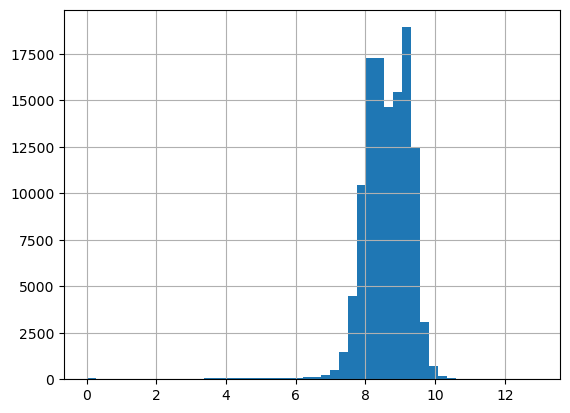

In [153]:
# idf_df['prix_m2_log'] = np.log1p(idf_df['prix_m2'])
# idf_df['prix_m2_log'].hist(bins=50)

In [154]:
# paris_df['date_transaction'] = pd.to_datetime(paris_df['date_transaction']).astype('int64')

In [199]:
X = idf_df[['n_pieces','surface_habitable','code_postal', 'longitude', 'latitude']].values
y = idf_df['prix_m2'].values

In [201]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (118624, 5)
Shape of y: (118624,)


In [202]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [204]:
print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(118624, 5) (118624,)
(94899, 5) (94899,)
(23725, 5) (23725,)


In [206]:
def plot_with_contour(model, X, y):
    
    # Visualisation des contours de décision
    x_min, x_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
    y_min, y_max = X[:, 1].min() - 0.01, X[:, 1].max() + 0.01
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.001),
                         np.arange(y_min, y_max, 0.001))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=1, cmap='coolwarm')
    
    # Normalize the colormap to ignore extreme values
    # sc = plt.scatter(X[:, 0], X[:, 1], c=y, vmin=0, vmax=20_2000,
    #                 marker='o', s=5, linewidth=1, cmap='coolwarm')
    
    sc = plt.scatter(X[:, 0], X[:, 1], c=y, vmin=np.percentile(y, 5), vmax=np.percentile(y, 95), 
                     marker='o', s=5, linewidth=1, cmap='coolwarm')
    
    
    # plt.colorbar(sc, label='prix m2', orientation='vertical')
    
    
    # plt.title("Contours de décision de l'arbre de décision" )
    # plt.xlabel("Longitude")
    # plt.ylabel("Latitude")
    # plt.show()

In [207]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

m = {DecisionTreeRegressor(max_depth=100), KNeighborsRegressor(n_neighbors=50), LinearRegression(), RandomForestRegressor(max_depth=100, min_samples_leaf=10, n_estimators=1000)}

for model in m:
    model.fit(X_train, y_train)
    # plot_with_contour(model, X, y)
    print (f"modele : {model}")
    print(np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
    print(np.sqrt(mean_squared_error(y_test, model.predict(X_test))))

modele : RandomForestRegressor(max_depth=100, min_samples_leaf=10, n_estimators=1000)
2213.4438861723015
3540.73088998692
modele : LinearRegression()
3697.3098475406264
4471.382396753997
modele : KNeighborsRegressor(n_neighbors=50)
2578.3280980792374
3647.2204347464667
modele : DecisionTreeRegressor(max_depth=100)
424.1335504519848
4505.803330154966


In [208]:
from sklearn.model_selection import GridSearchCV

params_grid = {
                'LR': {
                    'model': LinearRegression(),
                    'params': {
                        'fit_intercept': [True, False],
                        'positive': [True, False],
                    }
                },
                'KNR': {
                    'model': KNeighborsRegressor(),
                    'params': {
                        'n_neighbors': [10, 20, 50, 60],
                    }
                },
                'RFR': {
                    'model': RandomForestRegressor(),
                    'params': {
                        'max_depth': [50, 100, 150],
                        'min_samples_leaf': [20, 50],
                        'n_estimators': [500, 1000]

                    }
                }

            }

for model_name, model_config in params_grid.items():
    gs = GridSearchCV(estimator=model_config['model'], 
                      param_grid=model_config['params'],
                    
                      )
    gs.fit(X_train, y_train)
    print(f'Modèle: {model_name} avec params optimaux: {gs.best_params_} donne erreur =')
    print(np.sqrt(mean_squared_error(y_test, gs.best_estimator_.predict(X_test))))

Modèle: LR avec params optimaux: {'fit_intercept': True, 'positive': False} donne erreur =
4471.382396753997
Modèle: KNR avec params optimaux: {'n_neighbors': 20} donne erreur =
3643.4216469754906
Modèle: RFR avec params optimaux: {'max_depth': 50, 'min_samples_leaf': 20, 'n_estimators': 1000} donne erreur =
3559.260092536839


In [209]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [210]:
model = DecisionTreeRegressor(max_depth=2)
model.fit(X, y)

DecisionTreeRegressor(max_depth=2)

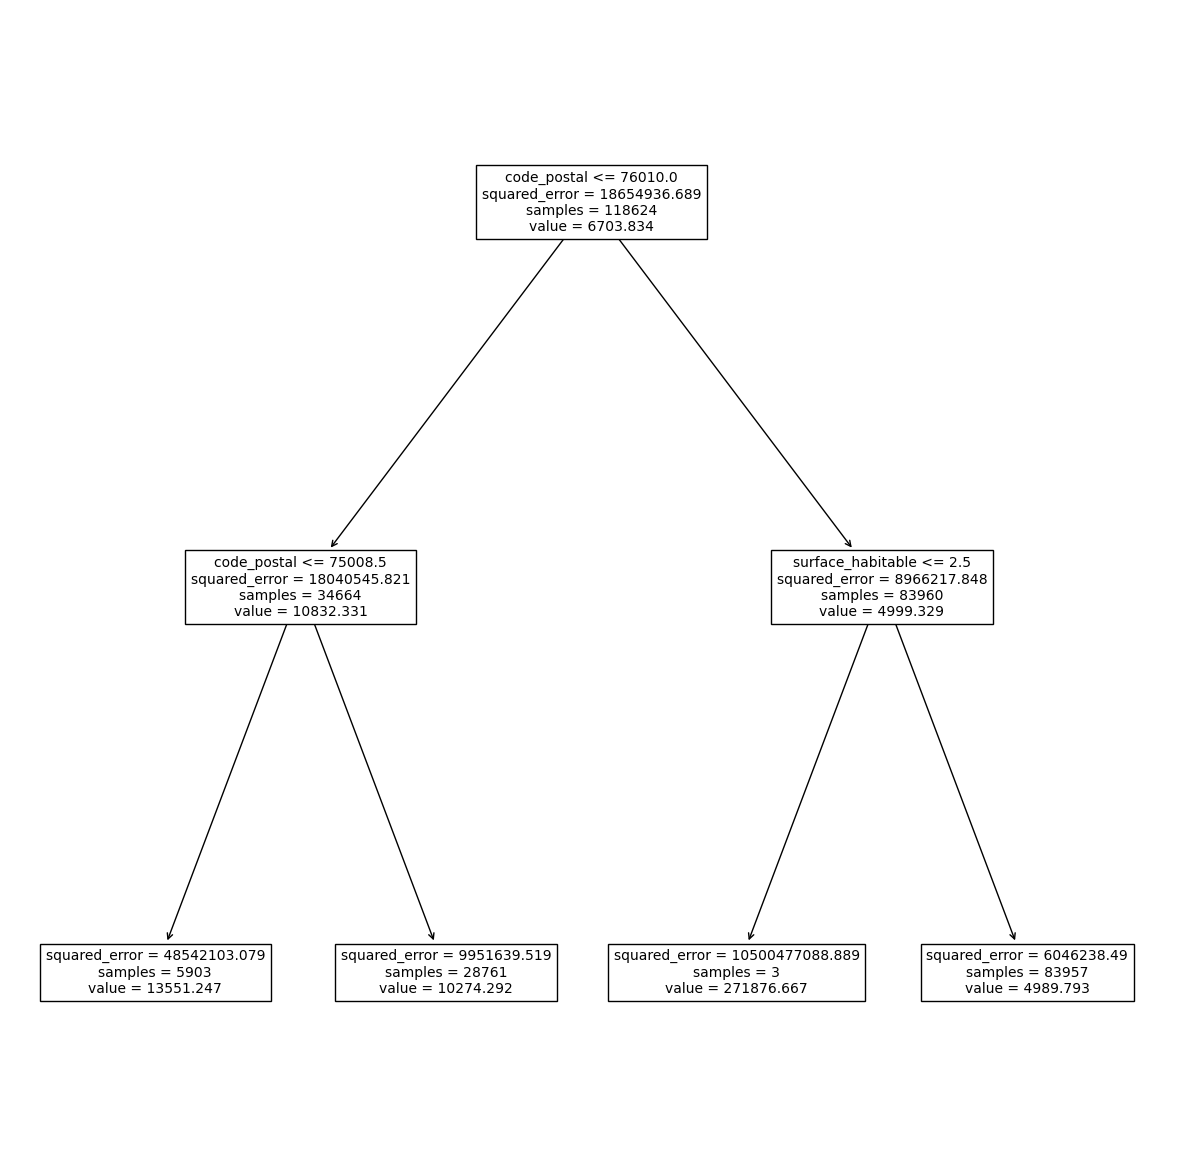

In [212]:
plt.figure(figsize=(15, 15))
plot_tree(model, feature_names=['n_pieces','surface_habitable', 'code_postal', 'longitude', 'latitude'], fontsize=10)
plt.show()

In [213]:
import pickle
from pprint import pprint

In [214]:
optimal_rfr_model = RandomForestRegressor(max_depth=50, min_samples_leaf=20, n_estimators=1000)
optimal_rfr_model.fit(X_train, y_train)

pickle.dump(optimal_rfr_model, open('optimal_rfr_model_idf.pkl', 'wb'))


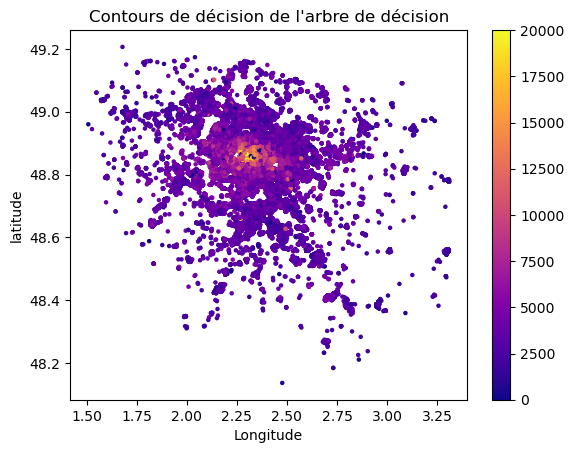

In [215]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

plt.scatter(idf_df['longitude'], idf_df['latitude'], c = idf_df.prix_m2, s=5, cmap="plasma", vmin=000, vmax=20000)
plt.title("Contours de décision de l'arbre de décision")
plt.xlabel("Longitude")
plt.ylabel("latitude")
plt.colorbar()